# Predict the effect of Genetic Variants

In [1]:
from __future__ import print_function
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


## 1. Loading Data

In [2]:
""" Read Data """
train_variant = pd.read_csv("input/training_variants")
test_variant = pd.read_csv("input/stage2_test_variants.csv")
train_text = pd.read_csv("input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("input/stage2_test_text.csv", header=None, skiprows=1, names=["ID", "Text"])
train = pd.merge(train_variant, train_text, how='left', on='ID')
train_y = train['Class'].values
train_x = train.drop('Class', axis=1)
train_size=len(train_x)
print('Number of training variants: %d' % (train_size))
# number of train data : 3321

test_x = pd.merge(test_variant, test_text, how='left', on='ID')
test_size=len(test_x)
print('Number of test variants: %d' % (test_size))
# number of test data : 5668

test_index = test_x['ID'].values
all_data = np.concatenate((train_x, test_x), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]

Number of training variants: 3321
Number of test variants: 986


In [3]:
all_data.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


## 2. Data Preprocessing

In [7]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", str(text))
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

allText = all_data['Text'].apply(cleanup)
sentences = constructLabeledSentences(allText)
allText.head()

0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [8]:
sentences[0]

LabeledSentence(words=['cyclindependent', 'kinases', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'processes', 'cdk10', 'stands', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'cdk10', 'silencing', 'increases', 'ets2', 'vets', 'erythroblastosis', 'virus', 'e26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cells', 'precise', 'mechanisms', 'cdk10', 'modulates', 'ets2', 'activity', 'generally', 'functions', 'cdk10', 'remain', 'elusive', 'demonstrate', 'cdk10', 'cyclindependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'm', 'orphan', 'cyclin', 'product', 'fam58a', 'whose', 'mutations', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'features', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformations', 'show', 'star', 'synd

## 3. Data Preparation and Features Extraction

### 3.1 Text Featurizer using Doc2Vec

Training Doc2Vec with your data or import a saved file

In [10]:
from gensim.models import Doc2Vec

Text_INPUT_DIM=300


text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

Featurize text for your training and testing dataset 

In [11]:
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1
    
print(text_train_arrays[0][:50])

[-0.37772793 -0.30491629 -0.15771501 -0.77964562 -0.1370369   0.29057276
  0.59170192  0.7486518   0.30679947  1.32701707  0.23944473 -0.24023375
  0.05159395  0.31542164  0.44716701 -0.56560963  0.8533867  -0.37447298
  0.58000445 -0.36486501 -0.00599538 -0.4909744   0.01143109  0.22986116
  0.12306259 -0.61172605 -0.67402071 -0.93751127  0.0510459  -0.72096157
  0.12796398  0.39616847 -0.36195704 -0.11357022  0.74828404 -0.88397485
  1.19343936  0.37072712 -0.53017801 -0.09862125 -0.19518007  0.04498016
 -0.24763723 -0.20057288 -0.62990141 -1.49423587 -0.20229441  0.25331813
 -0.51516306 -0.71433944]


### 3.2 Gene and Varation Featurizer

In [12]:
from sklearn.decomposition import TruncatedSVD
Gene_INPUT_DIM=25

svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

### 3.3 Output class encoding

In [13]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
print(encoded_y[0])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]


### 3.4 Merge Input features

In [14]:
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))
print(train_set[0][:50])

[ -2.46065582e-23  -5.21548048e-19  -1.95048372e-20  -2.44542833e-22
  -1.19176742e-22   1.61985461e-25   2.93618862e-25  -6.23860891e-27
   1.14583929e-28  -1.79996588e-29  -7.03545877e-30   2.56250679e-28
   2.03767376e-29   3.18392175e-27  -7.61828153e-27  -1.05689774e-26
   8.46143303e-26  -4.05026017e-26  -1.94048765e-26   3.83155530e-25
  -1.88986654e-25   2.08278604e-24  -1.96386955e-23   1.04464099e-22
  -1.21521208e-22   1.00000000e+00  -3.17319277e-20   1.87017685e-19
   1.91938139e-29   7.68633770e-29   3.05322655e-24   4.00346034e-24
  -3.61577413e-21   1.94144607e-21  -2.19442505e-21   4.04191661e-21
  -2.56517864e-21  -2.37830389e-20  -1.26767878e-20   1.62226542e-20
   1.34356710e-20   3.18596868e-18   1.37546264e-17   7.97588013e-18
  -7.94851379e-18   6.37605108e-18   5.31050109e-18   3.96202059e-17
   2.67450219e-18   1.52650276e-17]


In [15]:
# save pre-processed data to files
np.save('output/stage2_train_set.npy', train_set)
np.save('output/stage2_test_set.npy', test_set)
np.save('output/stage2_encoded_y.npy', encoded_y)
np.save('output/stage2_test_index.npy', test_index)

In [12]:
train_set = np.load('output/train_set.npy')
encoded_y = np.load('output/encoded_y.npy')
test_set = np.load('output/test_set.npy')
test_index = np.load('output/test_index.npy')
Text_INPUT_DIM=300
Gene_INPUT_DIM=25

## 4. Define Keras Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD

def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [17]:
model = baseline_model()
model.summary()

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=350, activation="relu", kernel_initializer="normal")`
  import sys
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  # This is added back by InteractiveShellApp.init_path()
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 729       
Total params: 176,937
Trainable params: 176,937
Non-trainable params: 0
_________________________________________________________________


## 5. Training and Evaluating the Model

Create estimator for training the model

In [18]:
estimator=model.fit(train_set, encoded_y, validation_split=0.2, epochs=10, batch_size=64)

Train on 2656 samples, validate on 665 samples
Epoch 1/10


  64/2656 [..............................] - ETA: 20s - loss: 2.1740 - acc: 0.1094

 320/2656 [==>...........................] - ETA: 4s - loss: 2.1570 - acc: 0.1531 

 512/2656 [====>.........................] - ETA: 2s - loss: 2.1368 - acc: 0.1855

 640/2656 [======>.......................] - ETA: 2s - loss: 2.1279 - acc: 0.1984

 960/2656 [=========>....................] - ETA: 1s - loss: 2.0996 - acc: 0.2052

1216/2656 [============>.................] - ETA: 0s - loss: 2.0630 - acc: 0.2188

1472/2656 [===============>..............] - ETA: 0s - loss: 2.0361 - acc: 0.2289

1728/2656 [==================>...........] - ETA: 0s - loss: 1.9977 - acc: 0.2390

1920/2656 [====================>.........] - ETA: 0s - loss: 1.9851 - acc: 0.2422

2304/2656 [=========================>....] - ETA: 0s - loss: 1.9581 - acc: 0.2582

2560/2656 [===========================>..] - ETA: 0s - loss: 1.9446 - acc: 0.2656

2656/2656 [==============================] - 1s - loss: 1.9425 - acc: 0.2673 - val_loss: 1.9466 - val_acc: 0.3444


Epoch 2/10


  64/2656 [..............................] - ETA: 0s - loss: 1.8486 - acc: 0.3438

 384/2656 [===>..........................] - ETA: 0s - loss: 1.8536 - acc: 0.2865

 640/2656 [======>.......................] - ETA: 0s - loss: 1.8474 - acc: 0.2922

 832/2656 [========>.....................] - ETA: 0s - loss: 1.8449 - acc: 0.3065

1088/2656 [===========>..................] - ETA: 0s - loss: 1.8338 - acc: 0.3180



1216/2656 [============>.................] - ETA: 0s - loss: 1.8326 - acc: 0.3207

1408/2656 [==============>...............] - ETA: 0s - loss: 1.8153 - acc: 0.3352

1664/2656 [=================>............] - ETA: 0s - loss: 1.8158 - acc: 0.3329

1920/2656 [====================>.........] - ETA: 0s - loss: 1.8118 - acc: 0.3349

2176/2656 [=======================>......] - ETA: 0s - loss: 1.7939 - acc: 0.3447

2432/2656 [==========================>...] - ETA: 0s - loss: 1.7819 - acc: 0.3536

2656/2656 [==============================] - 0s - loss: 1.7801 - acc: 0.3550 - val_loss: 1.8003 - val_acc: 0.3639


Epoch 3/10
  64/2656 [..............................] - ETA: 0s - loss: 1.7102 - acc: 0.3594

 256/2656 [=>............................] - ETA: 0s - loss: 1.7246 - acc: 0.3828

 512/2656 [====>.........................] - ETA: 0s - loss: 1.7399 - acc: 0.3711

 704/2656 [======>.......................] - ETA: 0s - loss: 1.7090 - acc: 0.3821

 896/2656 [=========>....................] - ETA: 0s - loss: 1.7004 - acc: 0.3929

1152/2656 [============>.................] - ETA: 0s - loss: 1.6892 - acc: 0.3924

1344/2656 [==============>...............] - ETA: 0s - loss: 1.6920 - acc: 0.3891

1536/2656 [================>.............] - ETA: 0s - loss: 1.6792 - acc: 0.3900

1728/2656 [==================>...........] - ETA: 0s - loss: 1.6685 - acc: 0.3895

1920/2656 [====================>.........] - ETA: 0s - loss: 1.6600 - acc: 0.3927

2048/2656 [======================>.......] - ETA: 0s - loss: 1.6530 - acc: 0.3921

2304/2656 [=========================>....] - ETA: 0s - loss: 1.6495 - acc: 0.3932

2496/2656 [===========================>..] - ETA: 0s - loss: 1.6439 - acc: 0.3970

2656/2656 [==============================] - 0s - loss: 1.6307 - acc: 0.4032 - val_loss: 1.7222 - val_acc: 0.2962


Epoch 4/10
  64/2656 [..............................] - ETA: 0s - loss: 1.5347 - acc: 0.4531



 256/2656 [=>............................] - ETA: 0s - loss: 1.5748 - acc: 0.4180

 512/2656 [====>.........................] - ETA: 0s - loss: 1.5710 - acc: 0.4258

 832/2656 [========>.....................] - ETA: 0s - loss: 1.5774 - acc: 0.4255

1024/2656 [==========>...................] - ETA: 0s - loss: 1.5833 - acc: 0.4238

1344/2656 [==============>...............] - ETA: 0s - loss: 1.5578 - acc: 0.4293

1600/2656 [=================>............] - ETA: 0s - loss: 1.5473 - acc: 0.4338

1728/2656 [==================>...........] - ETA: 0s - loss: 1.5508 - acc: 0.4346

1984/2656 [=====================>........] - ETA: 0s - loss: 1.5557 - acc: 0.4320

2240/2656 [========================>.....] - ETA: 0s - loss: 1.5526 - acc: 0.4326

2560/2656 [===========================>..] - ETA: 0s - loss: 1.5431 - acc: 0.4352

2656/2656 [==============================] - 0s - loss: 1.5402 - acc: 0.4383 - val_loss: 1.6744 - val_acc: 0.3293


Epoch 5/10


  64/2656 [..............................] - ETA: 0s - loss: 1.5787 - acc: 0.4531

 192/2656 [=>............................] - ETA: 1s - loss: 1.6026 - acc: 0.4219

 320/2656 [==>...........................] - ETA: 0s - loss: 1.5652 - acc: 0.4250



 512/2656 [====>.........................] - ETA: 0s - loss: 1.5154 - acc: 0.4414

 704/2656 [======>.......................] - ETA: 0s - loss: 1.5329 - acc: 0.4290

 896/2656 [=========>....................] - ETA: 0s - loss: 1.5351 - acc: 0.4219

1088/2656 [===========>..................] - ETA: 0s - loss: 1.5390 - acc: 0.4256

1216/2656 [============>.................] - ETA: 0s - loss: 1.5373 - acc: 0.4252

1408/2656 [==============>...............] - ETA: 0s - loss: 1.5245 - acc: 0.4361

1536/2656 [================>.............] - ETA: 0s - loss: 1.5051 - acc: 0.4440

1728/2656 [==================>...........] - ETA: 0s - loss: 1.4951 - acc: 0.4497

1920/2656 [====================>.........] - ETA: 0s - loss: 1.4936 - acc: 0.4526

2176/2656 [=======================>......] - ETA: 0s - loss: 1.4945 - acc: 0.4508

2432/2656 [==========================>...] - ETA: 0s - loss: 1.4946 - acc: 0.4544

2624/2656 [============================>.] - ETA: 0s - loss: 1.4975 - acc: 0.4516

2656/2656 [==============================] - 0s - loss: 1.4938 - acc: 0.4526 - val_loss: 1.6428 - val_acc: 0.3368


Epoch 6/10
  64/2656 [..............................] - ETA: 0s - loss: 1.5837 - acc: 0.4062

 256/2656 [=>............................] - ETA: 0s - loss: 1.3972 - acc: 0.4883

 384/2656 [===>..........................] - ETA: 0s - loss: 1.3605 - acc: 0.5052

 576/2656 [=====>........................] - ETA: 0s - loss: 1.4242 - acc: 0.4792

 704/2656 [======>.......................] - ETA: 0s - loss: 1.4320 - acc: 0.4645

 896/2656 [=========>....................] - ETA: 0s - loss: 1.4309 - acc: 0.4654

1152/2656 [============>.................] - ETA: 0s - loss: 1.4405 - acc: 0.4627

1408/2656 [==============>...............] - ETA: 0s - loss: 1.4475 - acc: 0.4496

1536/2656 [================>.............] - ETA: 0s - loss: 1.4350 - acc: 0.4629

1728/2656 [==================>...........] - ETA: 0s - loss: 1.4353 - acc: 0.4589

1984/2656 [=====================>........] - ETA: 0s - loss: 1.4315 - acc: 0.4572

2176/2656 [=======================>......] - ETA: 0s - loss: 1.4267 - acc: 0.4609

2368/2656 [=========================>....] - ETA: 0s - loss: 1.4311 - acc: 0.4620

2560/2656 [===========================>..] - ETA: 0s - loss: 1.4340 - acc: 0.4605

2656/2656 [==============================] - 0s - loss: 1.4321 - acc: 0.4612 - val_loss: 1.7025 - val_acc: 0.3173


Epoch 7/10
  64/2656 [..............................] - ETA: 0s - loss: 1.4124 - acc: 0.4531

 256/2656 [=>............................] - ETA: 0s - loss: 1.3946 - acc: 0.4648

 384/2656 [===>..........................] - ETA: 0s - loss: 1.3602 - acc: 0.5026

 576/2656 [=====>........................] - ETA: 0s - loss: 1.3878 - acc: 0.4826

 768/2656 [=======>......................] - ETA: 0s - loss: 1.3895 - acc: 0.4844

1024/2656 [==========>...................] - ETA: 0s - loss: 1.3919 - acc: 0.5029

1216/2656 [============>.................] - ETA: 0s - loss: 1.3843 - acc: 0.5033

1408/2656 [==============>...............] - ETA: 0s - loss: 1.3865 - acc: 0.5007

1664/2656 [=================>............] - ETA: 0s - loss: 1.3841 - acc: 0.5000

1920/2656 [====================>.........] - ETA: 0s - loss: 1.3748 - acc: 0.5010

2112/2656 [======================>.......] - ETA: 0s - loss: 1.3802 - acc: 0.5005

2240/2656 [========================>.....] - ETA: 0s - loss: 1.3753 - acc: 0.5027

2496/2656 [===========================>..] - ETA: 0s - loss: 1.3757 - acc: 0.4988

2656/2656 [==============================] - 0s - loss: 1.3787 - acc: 0.4966 - val_loss: 1.6424 - val_acc: 0.3218


Epoch 8/10
  64/2656 [..............................] - ETA: 0s - loss: 1.4313 - acc: 0.4375

 320/2656 [==>...........................] - ETA: 0s - loss: 1.3113 - acc: 0.5281

 576/2656 [=====>........................] - ETA: 0s - loss: 1.3432 - acc: 0.5035

 832/2656 [========>.....................] - ETA: 0s - loss: 1.3456 - acc: 0.4976

1088/2656 [===========>..................] - ETA: 0s - loss: 1.3542 - acc: 0.4917

1344/2656 [==============>...............] - ETA: 0s - loss: 1.3397 - acc: 0.4933

1664/2656 [=================>............] - ETA: 0s - loss: 1.3382 - acc: 0.5054

1920/2656 [====================>.........] - ETA: 0s - loss: 1.3342 - acc: 0.5083

2240/2656 [========================>.....] - ETA: 0s - loss: 1.3262 - acc: 0.5107

2496/2656 [===========================>..] - ETA: 0s - loss: 1.3181 - acc: 0.5124

2656/2656 [==============================] - 0s - loss: 1.3148 - acc: 0.5128 - val_loss: 1.7264 - val_acc: 0.3519


Epoch 9/10
  64/2656 [..............................] - ETA: 0s - loss: 1.5799 - acc: 0.3281

 256/2656 [=>............................] - ETA: 0s - loss: 1.4157 - acc: 0.4570

 512/2656 [====>.........................] - ETA: 0s - loss: 1.3362 - acc: 0.5195

 704/2656 [======>.......................] - ETA: 0s - loss: 1.2951 - acc: 0.5227

 960/2656 [=========>....................] - ETA: 0s - loss: 1.2909 - acc: 0.5167

1152/2656 [============>.................] - ETA: 0s - loss: 1.3026 - acc: 0.5148

1408/2656 [==============>...............] - ETA: 0s - loss: 1.2938 - acc: 0.5192

1664/2656 [=================>............] - ETA: 0s - loss: 1.2948 - acc: 0.5228

1920/2656 [====================>.........] - ETA: 0s - loss: 1.2837 - acc: 0.5276

2176/2656 [=======================>......] - ETA: 0s - loss: 1.2867 - acc: 0.5280

2368/2656 [=========================>....] - ETA: 0s - loss: 1.2858 - acc: 0.5253

2624/2656 [============================>.] - ETA: 0s - loss: 1.2745 - acc: 0.5309

2656/2656 [==============================] - 0s - loss: 1.2777 - acc: 0.5309 - val_loss: 1.6430 - val_acc: 0.3564


Epoch 10/10
  64/2656 [..............................] - ETA: 0s - loss: 1.5302 - acc: 0.4688

 192/2656 [=>............................] - ETA: 0s - loss: 1.2471 - acc: 0.5625

 448/2656 [====>.........................] - ETA: 0s - loss: 1.3134 - acc: 0.5312

 704/2656 [======>.......................] - ETA: 0s - loss: 1.2536 - acc: 0.5526

 896/2656 [=========>....................] - ETA: 0s - loss: 1.2352 - acc: 0.5525

1152/2656 [============>.................] - ETA: 0s - loss: 1.2391 - acc: 0.5538

1408/2656 [==============>...............] - ETA: 0s - loss: 1.2452 - acc: 0.5547

1600/2656 [=================>............] - ETA: 0s - loss: 1.2397 - acc: 0.5506

1856/2656 [===================>..........] - ETA: 0s - loss: 1.2438 - acc: 0.5480

2048/2656 [======================>.......] - ETA: 0s - loss: 1.2292 - acc: 0.5571

2176/2656 [=======================>......] - ETA: 0s - loss: 1.2259 - acc: 0.5579

2432/2656 [==========================>...] - ETA: 0s - loss: 1.2245 - acc: 0.5596

2656/2656 [==============================] - 0s - loss: 1.2229 - acc: 0.5629 - val_loss: 1.7371 - val_acc: 0.3293

Final model accuracy

In [19]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 56.29% / Validation accuracy: 32.93%


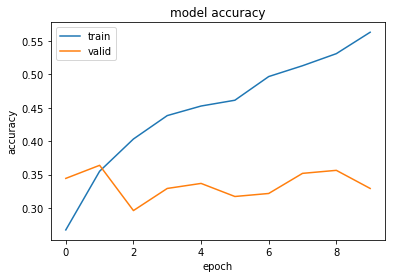

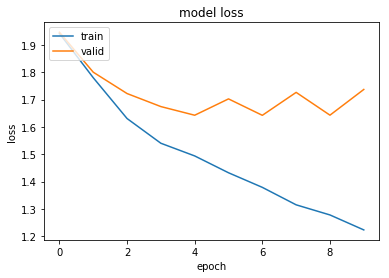

In [20]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 6. Make Predictions

In [21]:
y_pred = model.predict_proba(test_set)

 32/986 [..............................] - ETA: 1s

448/986 [============>.................] - ETA: 0s

896/986 [==========================>...] - ETA: 0s

In [22]:
y_pred

array([[ 0.14842291,  0.12464754,  0.08322176, ...,  0.1318766 ,
         0.05798589,  0.06974038],
       [ 0.19683099,  0.10420691,  0.07272425, ...,  0.1127661 ,
         0.0478007 ,  0.06000441],
       [ 0.14333634,  0.1308831 ,  0.08392872, ...,  0.13416493,
         0.05889304,  0.07024812],
       ..., 
       [ 0.14766429,  0.12664658,  0.08272153, ...,  0.13608125,
         0.05571295,  0.06783275],
       [ 0.15002599,  0.12086327,  0.08335487, ...,  0.13116889,
         0.05660741,  0.0681623 ],
       [ 0.14676918,  0.1275447 ,  0.08321683, ...,  0.13215722,
         0.05915524,  0.07097249]], dtype=float32)

Make Submission File

In [23]:
submission = pd.DataFrame(y_pred)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("stage2_submission_all.csv",index=False)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.148423,0.124648,0.083222,0.199558,0.110860,0.073687,0.131877,0.057986,0.069740,1
1,0.196831,0.104207,0.072724,0.229513,0.105503,0.070651,0.112766,0.047801,0.060004,2
2,0.143336,0.130883,0.083929,0.191428,0.111665,0.075452,0.134165,0.058893,0.070248,3
3,0.153835,0.118310,0.083027,0.208202,0.112347,0.073972,0.124316,0.057072,0.068919,4
4,0.138685,0.137246,0.083216,0.178659,0.110161,0.078313,0.148646,0.056723,0.068351,5


## 7. Layers Visualization

In [18]:
from keras import backend as K
import seaborn as sns

layer_of_interest=0
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[layer_of_interest].output])
intermediate_tensor = intermediate_tensor_function([train_set[0,:].reshape(1,-1)])[0]

In [19]:
import matplotlib
colors = list(matplotlib.colors.cnames)

intermediates = []
color_intermediates = []
for i in range(len(train_set)):
    output_class = np.argmax(encoded_y[i,:])
    intermediate_tensor = intermediate_tensor_function([train_set[i,:].reshape(1,-1)])[0]
    intermediates.append(intermediate_tensor[0])
    color_intermediates.append(colors[output_class])

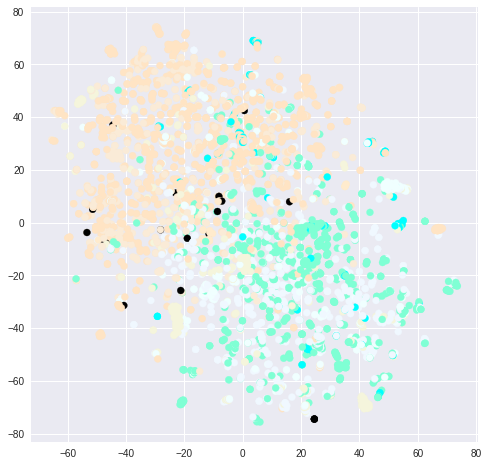

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()